The explanations and what I will apply is from and after reading ***A neural probabilistic language model paper*** *(Bengio, Y., et al, 2003)*

So we learned about n-grams language models, and how we can predict the next word given the $n$ previous words. And we implemented a **very simple** bigram model.  
Now, my next step was to understand word embeddings is how n-grams and statistical language modeling translated into neural networks and deep learning.

So in *(Bengio, Y., et al, 2003)*, the motivations they had is that it's difficult to model the joint probablity distribution of multiple consecutive words (random variables with **discrete** values.) An example would be having a sentence of 10 words where each one could have any value of a vocabulary of $100000$ words, so you have about $100000^{10}$ different possibilities or as they say "free parameters" for that sentence.

They also explained that modeling continuous variables is easier for generalization because the approximation function we want to learn is expected to **have** some smooth properties (neural networks would be a good example.) So the continuous space has a smoother space unlike discrete spaces where are more, idk, **discrete?** And they explain more about discrete spaces:  
***"For discrete spaces, the generalization structure is not as obvious: any change of these discrete variables may have a drastic impact on the value of the function to be estimated, and when the number of values that each discrete variable can take is large, most observed objects are almost maximally far from each other in hamming distance."***

**<u>Disclaimer:</u>**  
We are now going into the approach proposed and the mathematics and the design of it. Since I myself am trying to learn here, I won't be following the paper exactly here, meaning that I could:  
1.  Add a little bit more mathematics to give you and myself a better idea of what's happening.  
2.  Branch quickly in what I am writing to explain some other concepts that will help us understand what we have here better, which might be trivial to you depending on your level and knowledge so you can skip. But it won't be long anyway, this isn't an article (yet!)  

So previously, we learned that you can predict the next word $w_t$ given all previous ones:  
    $$P(w_t | w_{1:t-1}) \tag{1}$$  
    
But in n-grams, we wanted to approximate $(1)$ by using just the $n$ words before $w_t$ as follows:  
    $$P(w_t | w_{t-n+1:t-1}) \approx P(w_t | w_{1:t-1}) \tag{2}$$

Remember the joint probability equation, assuming there's a dependance between variables $x$, $y$, and $z$ (which in our case are words):
    $$P(x \cap y \cap z) = P(x, y, z) = P(z) P(y | z) P(x | z, y) \tag{3}$$
Which can be generalized to:
    $$P(x_i, x_{i-1}...x_{1}) = \prod_{k = 1}^n{P(x_k | x_1, x_2...x_{k-1})} \tag{4}$$

And now that we can approximate the probability of $w_t$, we can get the joint probability of a sentence or a sequence of words $W$ of length $T$:  

$$P(w_t w_{t-1}...w_1) = \prod_{k=1}^T{P(w_k | w_{k-n+1:k-1})} \tag{5}$$

This is the function we would want to maximize.

Side note for the joint probability in $(3)$: if we assumed there's no dependance between $x$, $y$, and $z$, we have:
    $$P(x, y, z) = P(x) P(y) P(z) \tag{6}$$

We are now want to use neural network to find a good function $f$ that approximates this joint probability distribution for a specific corpus. $f$ would have a set of trainable parameters $\Theta$.  
Now from above and $(2)$:  
$$P(w_t | w_{t-n+1:t-1}) \approx P(w_t | w_{1:t-1})$$
$$\approx f(w_t, w_{t-1}...w_{t-n+1};\Theta) \tag{7}$$

You can notice that $f$ uses $w_t$ and the n previous words $(w_{t-1}...w{t-n+1})$, just like we do in n-grams modelling.  
Now, from $(5)$ & $(7)$, we want to get the joint probability of the whole word sequence $W$ of word count $T$:
$$P(w_t w_{t-1}...w_1) = \prod_{k=1}^T{P(w_k | w_{k-n+1:k-1})} $$
$$\approx \prod_{t = 1}^T{f(w_t, w_{t-1}...w_{t-n+1};\Theta)} \tag{8}$$  

<u>What are the parameters included in $\Theta$?</u>

The parameters we have would depend on the model's architecture, we have mainly 2 parts (according to the architecture proposed in the text.):
1. Assuming we would have a set of vocabulary $V$ of size $|V|$, we want to create a mapping (a lookup table) $C$ for each word $w_i$ to a vector $v_{w_i}$ whose dimensions $\in \mathbb{R}^m$. In other words: $C(w_i) = v_{w_i} \mid v_{w_i} \in \mathbb{R}^m$.
2. The probability function $g$ that takes the mapping $C$ of the input words and maps them to the probability distribution over the vocab $V$.
    $$f(w_t, w_{t-1}...w_{t-n+1};\Theta) = g(i, C(w_{t-1}...w_{t-n+1}))$$

So $g$ outputs a vector of $|V|$ dimensions ($\in \mathbb{R}^{|V|}$), where the $i_{th}$ dimension or element corresponds to the probability of $i_{th}$ word being the next token:
$$\hat{P}(w_t=i | w_{1:t-1})$$

Then $C$ would be an $|V| \times m$ matrix. You can also say that $C$ is the word embeddings as a term we know of today.

We now want to start definining the loss function, which will be equivalent to $(8)$:
$$l = \prod_{t = 1}^T{f(w_t, w_{t-1}...w_{t-n+1};\Theta)} \tag{9}$$

We can transform the product into a summation by taking the log of both sides:
$$log(l) = log(\prod_{t = 1}^T{f(w_t, w_{t-1}...w_{t-n+1};\Theta)})$$
$$= \sum_{t = 1}^T{log(f(w_t, w_{t-1}...w_{t-n+1};\Theta))} \tag{10}$$
**<u>Why do we take the log:</u>**  
* Multiplying a lot of probabilities would make the resulting value approach $0$, or a numerical underflow when running on a computer which can mess up the calculations and results.
* Likewise if we were multiplying large numbers would result in an even bigger result, eventually leading to an overflow.

What we reached in $(10)$ is what we call Log Likelihood. So, from $(10)$, our loss function would be:
$$L = \frac{1}{T} \sum_{t = 1}^T{log(f(w_t, w_{t-1}...w_{t-n+1};\Theta))} \tag{11}$$

We can also add a Regularization function $R$ that regularizes the set of parameters $\Theta$, or a subset of $\Theta$ called $\Omega$:
$$L = \frac{1}{T} \sum_{t = 1}^T{log(f(w_t, w_{t-1}...w_{t-n+1};\Theta))} + R(\Omega) \tag{12}$$

But I won't use the regularized term $R(\Omega)$ in this implementation, so we will use $(11)$ as our Loss Function for the implementation.

Now for the network's architecture:  
<p align="center">
    <img src="../images/model_architecture.jpeg" alt="Bengio, et al. 2003" width="600"/>
</p>  

The first layer is the embeddings layer, then we have just one hidden layer before the $Softmax$ function. They also describe that **we can optionally connect the embeddings layer directly to the softmax layer.**

**<u>What what are the parameters we have?</u>**  

$$\Theta = (b, d, W, U, H, C)$$

| Parameter | Size | Optional | Description |
|:----------:|:----------:|:----------:|:----------:|
| $C$    | $\|V\| \times m$   | No   | The lookup table for the vector representation of each word in the vocabulary $\|V\|$.   |
| $H$    | $h \times (n-1) m$  | No   | The weights matrix for the hidden layer.   |
| $U$    | $\|V\| \times h$  | No   | The weights matrix for the hidden layer output to the softmax layer.   |
| $b$    | $\|V\|$  | No   | The output layer's biases.   |
| $d$    | $h$  | No   | The hidden layer's biases.   |
| $W$    | $\|V\| \times (n-1)m$  | Yes   | The weights matrix for optional connection between the embeddings layer and softmax layer.   |

Such that the logits of the output layer y that's passed to the softmax activation:
$$y = b + Wx + U tanh(d + Hx)$$

The softmax activation (predicted probability of word $w_t$ given the previous $n$):
$$\hat{P}(w_t | w_{t-1:t-n+1}) = \frac{\textit{e}^{y_{w_t}}}{\sum_{i}{\textit{e}^{y_i}}}$$


Perhaps that's enough reading, lets try to make a naive implementation of the architecture above with ***PyTorch***.  
And by ***naive*** I mean it's my first time building a Torch module that deals with sequences, so I probably won't do it the most efficient way.

# Neural Language Model

In [534]:
import torch
from torch import nn


# Our Neural Language Model class
class NLM(nn.Module):
    def __init__(self, v: int, m: int, n: int, h: int, padding_idx: int):
        super().__init__()
        self.v: int = v  #   Vocabulary size
        self.m: int = m  #   Embeddings dimensions
        self.n: int = n  #   Context size (the n-grams), we will actually input n-1 words to predict the n^th
        self.h: int = h  #   Hidden layer units (neurons)
        self.padding_idx: int = padding_idx  #   Indicates the index of the special token to be used to pad the a sequence of length < the context size

        #   I started with a randn tensor of shape (v, m) but turns out that Torch has a class for embeddings specifically,
        #   where this class stores the lookup table with numerical indices, so we still have to map the words to indices before entering the class
        #   or tokenization in other means
        self.c = nn.Embedding(
            num_embeddings=v, embedding_dim=m, padding_idx=padding_idx
        )

        #   This way, the linear/Activation layer will take flattened embeddings and produce v outputs
        #   I did it this way as per the paper which says that x (output of the embeddings) would be just the concatenation of all feature vectors
        #   But you can preserve the dimensionality of the of having each embedding vector seperately even with Linear layers
        #   by making the in_features=embedding dimensions
        self.linear1 = nn.Linear(in_features=m * (n - 1), out_features=h)
        self.tanh = nn.Tanh()

        #   The output layer, linear to create a logits and softmax activation to normalize them to probabilities
        self.linear2 = nn.Linear(
            in_features=h, out_features=v
        )  #   + 1 for the padding token
        self.softmax = nn.LogSoftmax(
            dim=-1
        )  #   Use log softmax because NLLoss function will expect log probabilities, spent some time debugging this :)

    def forward(self, x):
        embeddings = self.c(x)

        if (
            embeddings.dim() == 3
        ):  #   Its a batch input not single input, flatten each input's embeddings
            embeddings_flattened = embeddings.flatten(start_dim=1)
        else:  #   Single input, flatten the single input's embeddings
            embeddings_flattened = embeddings.flatten(start_dim=0)

        linear_activation = self.linear1(embeddings_flattened)
        non_linear_activation = self.tanh(linear_activation)

        logits = self.linear2(non_linear_activation)

        return logits

# Dataset 

I will try to stay close to the paper as much as I can, so we will use brown corpus from nltk, which should be the same they use in the paper, or at least **similar**.  
I don't want to drift off so we can compere the results we get to the ones in the paper, but any variations that I do from the one in the paper would probably mean different numbers which means I could've either drifted too much or implemented something incorrectly.

## Understand the dataset

In [2]:
import nltk
from nltk.corpus import brown

nltk.download("brown")
brown

[nltk_data] Downloading package brown to /Users/shadyali/nltk_data...
[nltk_data]   Package brown is already up-to-date!


<CategorizedTaggedCorpusReader in '/Users/shadyali/nltk_data/corpora/brown'>

In [3]:
brown.sents()

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

In [4]:
len(brown.words())

1161192

In [5]:
len(set(brown.words()))  # unique words

56057

In [6]:
non_words = [word for word in set(brown.words()) if not word.isalnum()]

In [7]:
dot_index = non_words.index(".")
non_words[dot_index : dot_index + 15]

['.',
 'nine-thirty',
 '4-d',
 'F.R.',
 'hard-liquor',
 "Sarah's",
 '1.10.4',
 'out-of-step',
 'Ter-Stepanova',
 'hit-and-miss',
 're-echo',
 '8-inch',
 'SP-44007',
 'war-time',
 'forward-moving']

So we have about $56k$ unique words, which includes punctuations, words mixed with punctuations, alphanumerals, etc.  
The paper replaced all words with frequency $< 3$ with a special token, let's call it \<unk>.  

<span style="color:red"> IMPORTANT NOTE: A MISTAKE I DID (I guess..)</span>  
I kept all words in my vocab, and did not even make them all in lower case, so I had about $56k$ words in my vocab. I also concatenated all words and did my own tokenization thing (You can check them out in older commits).  
And I struggled for like a **FULL WEEK** to figure out what I did wrong to get such a terrible results, not realizing it could possibly be because of tokenization and the way I split the *tokens*.  
Take care, tokenization is much more important than you think.

Let us keep the same tokenization done from nltk on brown corpus.  
But we will:  
1. Make all words lowercase.
2. Replace words with frequency $< 3$ with the \<unk> token. Which will also be the padding token.

In [8]:
# All lowercase
sentences = [[word.lower() for word in sentence] for sentence in list(brown.sents())]

In [9]:
# I want to flatten the sentences dimension first, then count each word frequency, then replace all < 3
words = [word for sentence in sentences for word in sentence]
word_counts = {word: 0 for word in words}
# this is years more efficient than using words.count(word) in dictionary comprehension above
for word in words:
    word_counts[word] += 1

In [10]:
for i, sentence in enumerate(sentences):
    for j, word in enumerate(sentence):
        if word_counts[word] <= 3:
            sentences[i][j] = "<unk>"
vocab = {word for sentence in sentences for word in sentence}
len(vocab)  #   Close enough to the paper

16690

## Tokenization

Our padding, special in other words, token will be $<unk>$, which we already added.

In [11]:
word_to_token = {word: token for token, word in enumerate(vocab)}
word_to_token["<unk>"]

6020

In [12]:
list(word_to_token.items())[:10]

[('revolution', 0),
 ('subsided', 1),
 ('facility', 2),
 ("morgan's", 3),
 ('ceased', 4),
 ('representations', 5),
 ('chic', 6),
 ('racket', 7),
 ('castles', 8),
 ('ice', 9)]

In [13]:
#   Tokenization function
def _tokenize(words: list[str]) -> list[int]:
    words = [word.lower() for word in words]
    tokens: list[int] = [
        word_to_token.get(word, word_to_token["<unk>"]) for word in words
    ]
    return tokens

Let's test encoding and tokenize on the full text now

In [14]:
test_sequence = ["Hello", ",", "my", "Dear"]
_tokenize(test_sequence)

[13642, 11706, 5940, 15894]

So there you have it! We can tokenize now

Lets structure our data for training now

## Structuring Dataset

We will do batch training, so we want to divide our corpus into batches of sequences.  
We will make a class for the dataset where it will create a list of a sliding window of $n-1$ words, and the $n^{th}$ is the label.  
The class the handle tokenization internally and will provide functions to encode and decode words to tokens and vice-versa.

In [ ]:
import torch
from torch.utils.data import Dataset


class Corpus(Dataset):
    def __init__(self, vocab: set[str], n: int, sentences: list[list[str]]):
        super().__init__()
        self.context_window: int = n

        self.vocab: set[str] = vocab
        self.vocab_length: int = len(vocab)

        self.word_to_token: dict[str, int] = {
            word: idx for idx, word in enumerate(vocab)
        }
        self.padding_token = word_to_token["<unk>"]

        self.token_to_word: dict[str, int] = {
            idx: word for idx, word in enumerate(vocab)
        }
        self.padding_word = ["<unk>"]

        self.sentences: list[list[str]] = sentences

        all_words = [word for sentence in self.sentences for word in sentence]
        self.full_text_tokenized: list[int] = self._tokenize(all_words)

        self.get_all_windows()

    def _tokenize(self, words: list[str]) -> list[int]:
        words = [word.lower() for word in words]
        tokens: list[int] = [
            word_to_token.get(word, word_to_token["<unk>"]) for word in words
        ]
        return tokens

    def tokenize_text(cls, text: list[str]) -> torch.Tensor:
        return torch.tensor(cls._tokenize(text))

    def decode(self, tokens: torch.Tensor) -> list[str]:
        tokens = (
            tokens.tolist() if tokens.shape else [tokens.tolist()]
        )  # A scaler value will output the value without list, raising an error below

        words: list[int] = [self.token_to_word[token] for token in tokens]
        return words

    def get_all_windows(self) -> None:
        self.input_tokens = []
        self.next_token = []

        corpus_size = len(self.full_text_tokenized)
        for index in range(corpus_size):
            if index + self.context_window - 1 < corpus_size:
                self.input_tokens.append(
                    self.full_text_tokenized[index : index + self.context_window - 1]
                )
                self.next_token.append(
                    self.full_text_tokenized[index + self.context_window - 1]
                )

    def __len__(self):
        return len(self.input_tokens)

    def __getitem__(self, window):
        return torch.tensor(self.input_tokens[window]), torch.tensor(
            self.next_token[window]
        )

In [16]:
dataset = Corpus(vocab=vocab, n=4, sentences=sentences)

In [17]:
dataset[0]

(tensor([ 3308, 13396, 12442]), tensor(517))

In [18]:
dataset.tokenize_text(["I", "Love", "ham"])

tensor([ 5930,  1436, 10984])

In [19]:
dataset.decode(dataset[67][0]), dataset.decode(dataset[67][1])

(['.', 'the', '<unk>'], ['term'])

We can now use the DataLoader class to get an iterator to produce batches of training data for us

In [20]:
from torch.utils.data import DataLoader

data_iterator = iter(DataLoader(dataset=dataset, batch_size=2, shuffle=True))

In [21]:
input, label = next(data_iterator)
print(f"Feature batch shape: {input.shape}")
print(f"Labels batch shape: {label.shape}")

Feature batch shape: torch.Size([2, 3])
Labels batch shape: torch.Size([2])


The loader is working!!

I think we are ready now to split our data, ***AND TRAIN OUR MODEL***

# MODEL TRAINING

## Setup

Let's setup our model and move it to the GPU

MPS is the GPU backend for Macs, so change it to CUDA if you're using Nvidia driver.

In [186]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device

'mps'

I will try to replicate the same hyper parameters used in the experiments, I won't do every combination though.
For now lets do:  
* n = 5
* h = 100
* m = 30
* direct = No       <br>*There's no direct connections from the embeddings layer to the output*</br>
* mix = No          <br>*Mixing the model with other models like n-grams (if I understood correctly)*</br>

In [187]:
dataset = Corpus(n=5, vocab=vocab, sentences=sentences)

In [813]:
nlm = NLM(v=dataset.vocab_length, m=30, n=5, h=100, padding_idx=dataset.padding_token)
nlm.to(device)

NLM(
  (c): Embedding(16690, 30, padding_idx=6020)
  (linear1): Linear(in_features=120, out_features=100, bias=True)
  (tanh): Tanh()
  (linear2): Linear(in_features=100, out_features=16690, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

For our loss function, we will use the ***Negative Log Likelihood*** instead of ***Log Likelihood*** to make our goal be minimizing instead of maximizing.  
So we will just add a negative sign to equation $(11)$:  
$$L = \frac{1}{T} \sum_{t = 1}^T{-log(f(w_t, w_{t-1}...w_{t-n+1};\Theta))} \tag{13}$$

We will make our ***learning rate*** $\epsilon_o = 10^{-2}$ (supposed to be $10^{-3}$ but that would make the training much slower with low batch size, I'll explain this later.), will use a scheduler $\epsilon_t = \frac{\epsilon_o}{1 + rt}$ to decrease the rate, where $r = 10^{-8}$ is the decrease factor and $t$ is the number of parameter updates done.  
I'm not entirely sure what optimizer they use, but I believe it's ***Stochastic Gradient Descent*** as they mention it in section $3.1$ for each CPU update.
They also mention a weight decay penalty of $10^{-4}$ in section $4.2$

In [814]:
learning_rate = 0.025

loss_function = nn.NLLLoss()

optimizer = torch.optim.SGD(
    params=nlm.parameters(), lr=learning_rate, weight_decay=1e-4
)

Lets define the learning rate scheduler

In [815]:
# LambdaLR allows you to define a specific function that uses epoch and multiplies that function by the current learning rate
r = 1e-8
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer=optimizer, lr_lambda=lambda epoch: 1 / (1 + r * epoch)
)

Split the dataset

In [816]:
len(dataset)

1161188

In [817]:
from torch.utils.data import Subset

indices = list(range(len(dataset)))

train_size = 800000
validation_size = 200000
test_size = 161188

train_set = Subset(dataset=dataset, indices=indices[:train_size])

validation_set = Subset(
    dataset=dataset, indices=indices[train_size : train_size + validation_size]
)

test_set = Subset(dataset=dataset, indices=indices[train_size + validation_size :])

Lets compute the perplexity as our metric since the paper uses it.  
* Perplexity measures the uncertainty the model has when predicting the next token.  
* So a smaller perplexity means a more certain model.

In [818]:
from torcheval.metrics.text import Perplexity


def calculate_perplexity(vocab_length, dataset, batch_size, model):
    perplexity = Perplexity(
        ignore_index=vocab_length,
    )

    data_iterator = iter(
        DataLoader(
            dataset=dataset,
            batch_size=model.n * batch_size,
        )
    )

    model.eval()
    with torch.no_grad():
        for inputs, labels in data_iterator:
            y_train_log_probs = model(inputs.to(device))

            perplexity.update(y_train_log_probs.cpu().unsqueeze(1), labels.unsqueeze(1))

            del inputs, labels, y_train_log_probs
            torch.mps.empty_cache()
        score = perplexity.compute()
    model.train()

    return score

## THE TRAINING LOOP

I will use some configurations from my last project for the loop

In [819]:
from torch.utils.data import DataLoader
from tqdm import tqdm


def train(dataset, batch_size, epochs, model, validation_set):
    train_batch_loss = []
    train_epoch_loss = []
    train_learning_rate = []

    model.train()
    for _ in range(epochs):
        data_iterator = iter(
            DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
        )

        batch_info = {}

        with tqdm(
            enumerate(data_iterator),
            total=len(data_iterator),
            desc="Training",
            unit="Batch",
        ) as batches:
            for batch_index, (inputs, labels) in batches:
                optimizer.zero_grad()

                inputs, labels = inputs.to(device), labels.to(device)
                predicted_log_probabilites = model.softmax(
                    model(inputs)
                )  # apply log_softmax here to the logits as the loss function expects log probabilities

                loss = loss_function(predicted_log_probabilites, labels)

                loss.backward()
                optimizer.step()

                if batch_index % 100 == 0:
                    batch_info["Loss"] = f"{loss.item(): .3f}"
                    batch_info["Learning Rate"] = (
                        f"{lr_scheduler.get_last_lr()[-1]: .4f}"
                    )
                    batches.set_postfix(batch_info)

                train_batch_loss.append(loss.item())

                # Clear memory for batch data
                del inputs, labels, predicted_log_probabilites
                torch.mps.empty_cache()

            train_epoch_loss.append(torch.tensor(train_batch_loss).mean().item())
            train_learning_rate.append(lr_scheduler.get_last_lr()[-1])

            batch_info["Loss"] = f"{train_epoch_loss[-1]: .3f}"
            batch_info["Perplexity"] = (
                f"{calculate_perplexity(model.v, dataset=validation_set, batch_size=3000, model=model)}"
            )
            batches.write(str(batch_info), end="\n\n")

            lr_scheduler.step()

    return train_batch_loss, train_epoch_loss, train_learning_rate


In [820]:
from matplotlib import pyplot as plt


def plot_training_data(train_batch_loss, train_epoch_loss, train_learning_rate):
    fig, axs = plt.subplots(1, 3)

    axs[0].plot(range(len(train_batch_loss)), train_batch_loss)
    axs[0].set_title("Batch Loss")

    axs[1].plot(range(len(train_epoch_loss)), train_epoch_loss)
    axs[1].set_title("Epoch Loss")

    axs[2].plot(range(len(train_learning_rate)), train_learning_rate)
    axs[2].set_title("Learning Rate")

    fig.set_figwidth(20)
    fig.set_figheight(5)

    plt.tight_layout()
    plt.show()

Let's call the training and plotting functions here.

Training: 100%|██████████| 100000/100000 [08:26<00:00, 197.29Batch/s, Loss=6.058, Learning Rate=0.0250]


{'Loss': ' 6.313', 'Learning Rate': ' 0.0250', 'Perplexity': '451.07620268850366'}



Training: 100%|██████████| 100000/100000 [08:27<00:00, 197.11Batch/s, Loss=7.010, Learning Rate=0.0250]


{'Loss': ' 6.157', 'Learning Rate': ' 0.0250', 'Perplexity': '405.499629933583'}



Training: 100%|██████████| 100000/100000 [08:49<00:00, 188.77Batch/s, Loss=6.094, Learning Rate=0.0250]


{'Loss': ' 6.069', 'Learning Rate': ' 0.0250', 'Perplexity': '376.64498026948144'}



Training: 100%|██████████| 100000/100000 [08:48<00:00, 189.04Batch/s, Loss=5.455, Learning Rate=0.0250]


{'Loss': ' 6.006', 'Learning Rate': ' 0.0250', 'Perplexity': '361.542775112664'}



Training: 100%|██████████| 100000/100000 [08:48<00:00, 189.26Batch/s, Loss=4.113, Learning Rate=0.0250]


{'Loss': ' 5.957', 'Learning Rate': ' 0.0250', 'Perplexity': '346.1729095008697'}



Training: 100%|██████████| 100000/100000 [08:48<00:00, 189.09Batch/s, Loss=5.885, Learning Rate=0.0250]


{'Loss': ' 5.916', 'Learning Rate': ' 0.0250', 'Perplexity': '334.5345020968544'}



Training: 100%|██████████| 100000/100000 [08:44<00:00, 190.78Batch/s, Loss=6.213, Learning Rate=0.0250]


{'Loss': ' 5.880', 'Learning Rate': ' 0.0250', 'Perplexity': '324.1969372347557'}



Training: 100%|██████████| 100000/100000 [08:47<00:00, 189.54Batch/s, Loss=7.743, Learning Rate=0.0250]


{'Loss': ' 5.847', 'Learning Rate': ' 0.0250', 'Perplexity': '309.0963881642434'}



Training: 100%|██████████| 100000/100000 [08:42<00:00, 191.44Batch/s, Loss=6.730, Learning Rate=0.0250]


{'Loss': ' 5.818', 'Learning Rate': ' 0.0250', 'Perplexity': '306.58966091804234'}



Training: 100%|██████████| 100000/100000 [08:41<00:00, 191.73Batch/s, Loss=5.324, Learning Rate=0.0250]


{'Loss': ' 5.791', 'Learning Rate': ' 0.0250', 'Perplexity': '296.4122525539173'}



Training: 100%|██████████| 100000/100000 [08:41<00:00, 191.65Batch/s, Loss=4.714, Learning Rate=0.0250]


{'Loss': ' 5.766', 'Learning Rate': ' 0.0250', 'Perplexity': '290.94869429401547'}



Training: 100%|██████████| 100000/100000 [08:41<00:00, 191.63Batch/s, Loss=6.529, Learning Rate=0.0250]


{'Loss': ' 5.743', 'Learning Rate': ' 0.0250', 'Perplexity': '286.00238400998967'}



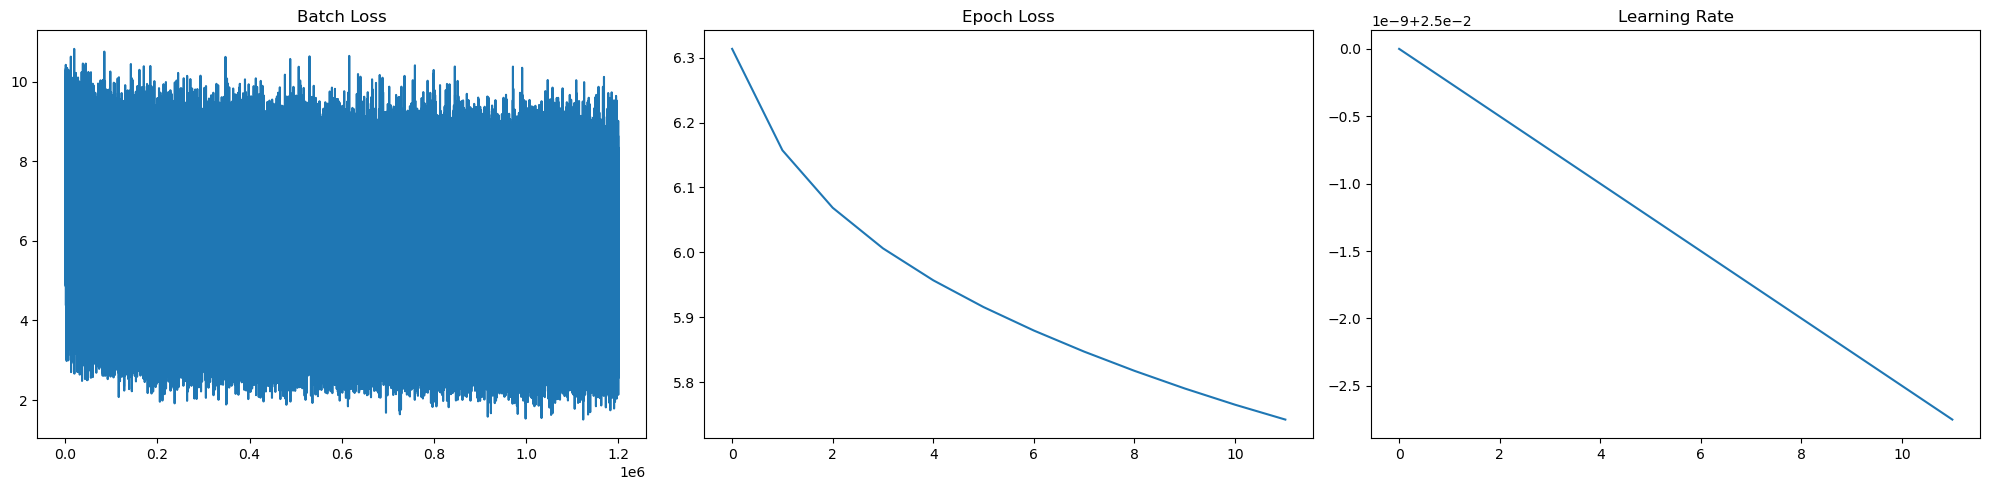

In [821]:
train_batch_loss, train_epoch_loss, train_learning_rate = train(
    dataset=train_set,
    batch_size=8,
    epochs=12,
    model=nlm,
    validation_set=validation_set,
)
plot_training_data(train_batch_loss, train_epoch_loss, train_learning_rate)

## Evaluation

In [822]:
calculate_perplexity(
    vocab_length=dataset.vocab_length, dataset=test_set, batch_size=3000, model=nlm
)

tensor(266.6692, dtype=torch.float64)

Let's see how close are the embeddings of things we would expect to be similar now. 

In [837]:
cat_token = dataset.word_to_token["cat"]
dog_token = dataset.word_to_token["dog"]
car_token = dataset.word_to_token["ball"]
with torch.no_grad():
    nlm.eval()
    embeddings = nlm.c(torch.tensor([cat_token, dog_token, car_token]).to(device))
    nlm.train()
embeddings.shape

torch.Size([3, 30])

In [838]:
torch.cosine_similarity(embeddings[0], embeddings[1], dim=-1)  # Cat and Dog

tensor(0.2351, device='mps:0')

In [ ]:
torch.cosine_similarity(embeddings[1], embeddings[2], dim=-1)  # Dog and Ball

tensor(0.1916, device='mps:0')

In [ ]:
torch.cosine_similarity(embeddings[0], embeddings[2], dim=-1)  # Cat and Ball

tensor(0.0362, device='mps:0')

In [827]:
import random


def generate_sentence(model, dataset, sentence: str = ""):
    context_size = model.n - 1
    if sentence:
        tokens: list[int] = dataset.tokenize(sentence.lower().split(" ")[-model.n :])
    else:
        tokens = [model.padding_idx for _ in range(model.n - 1)]
        tokens.append(random.randint(0, dataset.vocab_length))

    tokens = torch.tensor(tokens[-context_size:])
    while True:
        with torch.no_grad():
            model.zero_grad()

            next_tokens = model(tokens[-context_size:].to(device))
            next_token = next_tokens.softmax(-1).argmax().cpu()

        tokens = torch.cat([tokens, torch.tensor([next_token])])
        print(tokens[-context_size:])
        # print(" ".join([dataset.decode(token)[0] for token in tokens]), end="\r")
        if dataset.decode(next_token) == "<unk>" or dataset.decode(next_token) == ".":
            break

    return " ".join([dataset.decode(token)[0] for token in tokens])

In [828]:
# generate_sentence(nlm, dataset)

In [829]:
input = "really love when the".lower().split(" ")

with torch.no_grad():
    nlm.zero_grad()
    next_token = nlm(dataset.tokenize_text(input).to(device))
    best = next_token.softmax(-1)

In [830]:
dataset.decode(best.argmax().cpu())

['<unk>']

In [831]:
# import gc

# gc.collect()
# torch.mps.empty_cache()